In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import TransformerModel, HybridCNNTransformer
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bands = 4 #밴드 수
patch_size = 9
num_epochs = 100

In [3]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    return x

transform = get_transform(bands, scale_channels)

In [5]:
val_filters = [
    lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49} ,
    lambda x: x >= 2 and (x % 50) in {2, 7, 14, 19, 21, 26, 33, 38, 45, 0}  ,
    lambda x: x >= 3 and (x % 50) in {3, 8, 15, 20, 22, 27, 34, 39, 41, 46},
    lambda x: x >= 4 and (x % 50) in {4, 9, 11, 16, 23, 28, 35, 40, 42, 47 }  ,
    lambda x: x >= 5 and (x % 50) in {5, 10, 12, 17, 24, 29, 31, 36, 43, 48},
]

In [6]:
result_df = {} #반환하는 데이터 프레임을 딕셔너리로 만들기

for idx, val_filter in enumerate(val_filters):
    #data loader만들기
    val_dataset = TiffDataset(
        large_tif_dir = '../../data/source_data/naive',
        file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
        label_file ="../../data/label_data/species/label_mapping_sampled.csv",
        box_filter_fn = val_filter,
        patch_size = patch_size,
        transform=transform
    )
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    #모델 생성, pth 업로드
    model = TransformerModel().to(device)
    model.load_state_dict(torch.load(f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}_{idx}.pth", map_location=device))
    
    #결과 딕셔너리에 추가
    result_df[idx] = evaluate_model_with_cm(model, val_loader, num_classes=6)
    
    #메모리 확보
    del model, val_loader
    torch.cuda.empty_cache()
    
# 결과 저장 경로 설정
save_path = "./results/transformer_262674.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 모든 데이터프레임을 하나로 합치기
dfs = []
for key, df in result_df.items():
    df = df.copy()
    df["dataset"] = key  # 데이터셋 열 추가
    df = df.reset_index().rename(columns={"index": "class"})
    dfs.append(df)

# 데이터프레임 병합
final_df = pd.concat(dfs, ignore_index=True)

# CSV 저장
final_df.to_csv(save_path, encoding="utf-8-sig", index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

RuntimeError: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "norm_input.weight", "norm_input.bias", "transformer.encoder.layers.0.self_attn.in_proj_weight", "transformer.encoder.layers.0.self_attn.in_proj_bias", "transformer.encoder.layers.0.self_attn.out_proj.weight", "transformer.encoder.layers.0.self_attn.out_proj.bias", "transformer.encoder.layers.0.linear1.weight", "transformer.encoder.layers.0.linear1.bias", "transformer.encoder.layers.0.linear2.weight", "transformer.encoder.layers.0.linear2.bias", "transformer.encoder.layers.0.norm1.weight", "transformer.encoder.layers.0.norm1.bias", "transformer.encoder.layers.0.norm2.weight", "transformer.encoder.layers.0.norm2.bias", "transformer.encoder.layers.1.self_attn.in_proj_weight", "transformer.encoder.layers.1.self_attn.in_proj_bias", "transformer.encoder.layers.1.self_attn.out_proj.weight", "transformer.encoder.layers.1.self_attn.out_proj.bias", "transformer.encoder.layers.1.linear1.weight", "transformer.encoder.layers.1.linear1.bias", "transformer.encoder.layers.1.linear2.weight", "transformer.encoder.layers.1.linear2.bias", "transformer.encoder.layers.1.norm1.weight", "transformer.encoder.layers.1.norm1.bias", "transformer.encoder.layers.1.norm2.weight", "transformer.encoder.layers.1.norm2.bias", "transformer.encoder.layers.2.self_attn.in_proj_weight", "transformer.encoder.layers.2.self_attn.in_proj_bias", "transformer.encoder.layers.2.self_attn.out_proj.weight", "transformer.encoder.layers.2.self_attn.out_proj.bias", "transformer.encoder.layers.2.linear1.weight", "transformer.encoder.layers.2.linear1.bias", "transformer.encoder.layers.2.linear2.weight", "transformer.encoder.layers.2.linear2.bias", "transformer.encoder.layers.2.norm1.weight", "transformer.encoder.layers.2.norm1.bias", "transformer.encoder.layers.2.norm2.weight", "transformer.encoder.layers.2.norm2.bias", "transformer.encoder.layers.3.self_attn.in_proj_weight", "transformer.encoder.layers.3.self_attn.in_proj_bias", "transformer.encoder.layers.3.self_attn.out_proj.weight", "transformer.encoder.layers.3.self_attn.out_proj.bias", "transformer.encoder.layers.3.linear1.weight", "transformer.encoder.layers.3.linear1.bias", "transformer.encoder.layers.3.linear2.weight", "transformer.encoder.layers.3.linear2.bias", "transformer.encoder.layers.3.norm1.weight", "transformer.encoder.layers.3.norm1.bias", "transformer.encoder.layers.3.norm2.weight", "transformer.encoder.layers.3.norm2.bias", "norm_out.weight", "norm_out.bias". 
	Unexpected key(s) in state_dict: "norm1.weight", "norm1.bias", "norm2.weight", "norm2.bias", "transformer.layers.0.self_attn.in_proj_weight", "transformer.layers.0.self_attn.in_proj_bias", "transformer.layers.0.self_attn.out_proj.weight", "transformer.layers.0.self_attn.out_proj.bias", "transformer.layers.0.linear1.weight", "transformer.layers.0.linear1.bias", "transformer.layers.0.linear2.weight", "transformer.layers.0.linear2.bias", "transformer.layers.0.norm1.weight", "transformer.layers.0.norm1.bias", "transformer.layers.0.norm2.weight", "transformer.layers.0.norm2.bias", "transformer.layers.1.self_attn.in_proj_weight", "transformer.layers.1.self_attn.in_proj_bias", "transformer.layers.1.self_attn.out_proj.weight", "transformer.layers.1.self_attn.out_proj.bias", "transformer.layers.1.linear1.weight", "transformer.layers.1.linear1.bias", "transformer.layers.1.linear2.weight", "transformer.layers.1.linear2.bias", "transformer.layers.1.norm1.weight", "transformer.layers.1.norm1.bias", "transformer.layers.1.norm2.weight", "transformer.layers.1.norm2.bias", "transformer.layers.2.self_attn.in_proj_weight", "transformer.layers.2.self_attn.in_proj_bias", "transformer.layers.2.self_attn.out_proj.weight", "transformer.layers.2.self_attn.out_proj.bias", "transformer.layers.2.linear1.weight", "transformer.layers.2.linear1.bias", "transformer.layers.2.linear2.weight", "transformer.layers.2.linear2.bias", "transformer.layers.2.norm1.weight", "transformer.layers.2.norm1.bias", "transformer.layers.2.norm2.weight", "transformer.layers.2.norm2.bias", "transformer.layers.3.self_attn.in_proj_weight", "transformer.layers.3.self_attn.in_proj_bias", "transformer.layers.3.self_attn.out_proj.weight", "transformer.layers.3.self_attn.out_proj.bias", "transformer.layers.3.linear1.weight", "transformer.layers.3.linear1.bias", "transformer.layers.3.linear2.weight", "transformer.layers.3.linear2.bias", "transformer.layers.3.norm1.weight", "transformer.layers.3.norm1.bias", "transformer.layers.3.norm2.weight", "transformer.layers.3.norm2.bias". 

In [6]:
final_df

,class,precision,recall,f1-score,support,Category,dataset
0,Non-Forest,0.964127,0.965660,0.964893,3145.000000,Overall,0
1,Pine,0.801082,0.859567,0.829295,4479.000000,Overall,0
2,Nut Pine,0.871254,0.833576,0.851999,4116.000000,Overall,0
3,Larch,0.945602,0.928386,0.936915,5767.000000,Overall,0
4,Mongolian Oak,0.774189,0.879407,0.823450,6269.000000,Overall,0
...,...,...,...,...,...,...,...
120,Mongolian Oak,0.804093,0.743984,0.772872,5070.000000,Broadleaf,4
121,Oriental Oak,0.721698,0.785531,0.752263,4285.000000,Broadleaf,4
122,accuracy,0.763014,0.763014,0.763014,0.763014,Broadleaf,4
123,macro avg,0.762896,0.764758,0.762567,9355.000000,Broadleaf,4


Evaluation Progress: 100%|███████████████████████████████████| 936/936 [00:09<00:00, 94.73it/s]


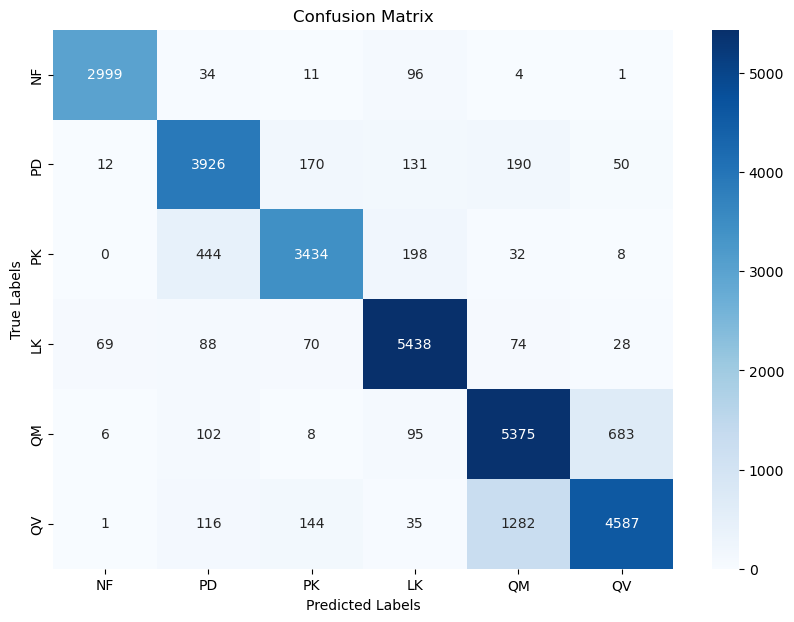

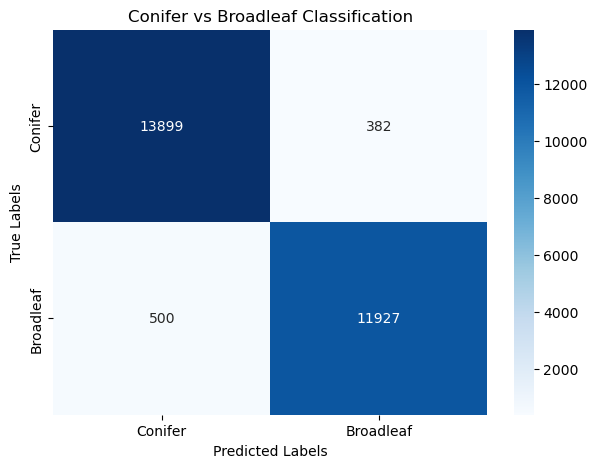

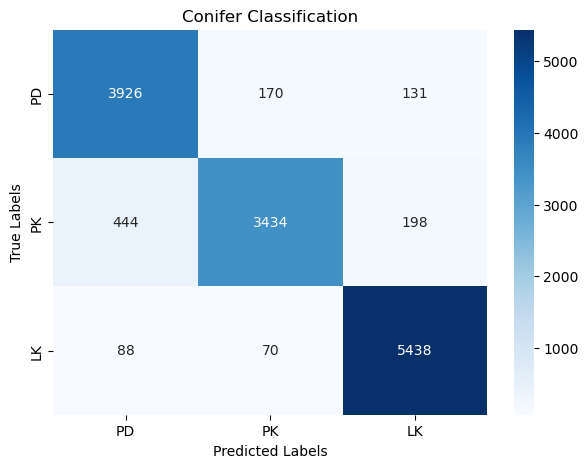

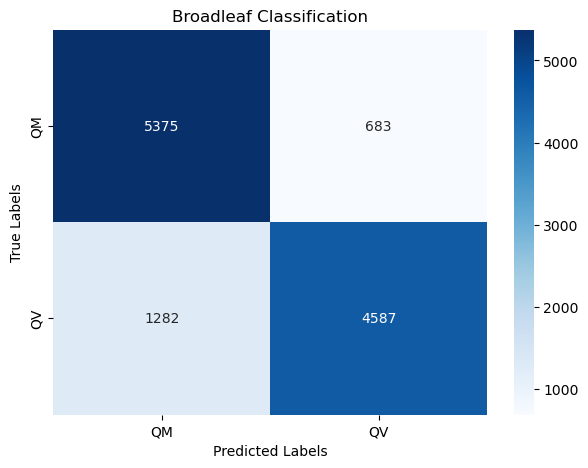

KeyboardInterrupt: 

In [7]:
result_df = {} #반환하는 데이터 프레임을 딕셔너리로 만들기

for idx, val_filter in enumerate(val_filters):
    #data loader만들기
    val_dataset = TiffDataset(
        large_tif_dir = '../../data/source_data/naive',
        file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
        label_file ="../../data/label_data/species/label_mapping_sampled.csv",
        box_filter_fn = val_filter,
        patch_size = patch_size,
        transform=transform
        
    )
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    #모델 생성, pth 업로드
    model = HybridCNNTransformer().to(device)
    model.load_state_dict(torch.load(f"./checkpoints/hybrid/hybrid_{bands}_{patch_size}_{num_epochs}_{idx}.pth", map_location=device))
    
    #결과 딕셔너리에 추가
    result_df[idx] = evaluate_model_with_cm(model, val_loader, num_classes=6)
    
    #메모리 확보
    del model, val_loader
    torch.cuda.empty_cache()
    
# 결과 저장 경로 설정
save_path = "./results/hybrid_251570.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 모든 데이터프레임을 하나로 합치기
dfs = []
for key, df in result_df.items():
    df = df.copy()
    df["dataset"] = key  # 데이터셋 열 추가
    df = df.reset_index().rename(columns={"index": "class"})
    dfs.append(df)

# 데이터프레임 병합
final_df = pd.concat(dfs, ignore_index=True)

# CSV 저장
final_df.to_csv(save_path, encoding="utf-8-sig", index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

In [ ]:
final_df